In [1]:
import tensorflow as tf
#Vers. 1.0.0
print(tf.__version__)
import sys
#Should be above 3.5
#print (sys.version)     

import cv2
import numpy as np
import os
import glob
import pickle

import matplotlib.image as mpimg
from skimage import color

import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

from Helpers import get_files, load_image, separate_imgs, get_next_batch_from_disk, get_next_batch_from_disk2

1.0.0


In [2]:
images_list = get_files("..\Data\Images\\*", '*.jpg')


# Building the Training set


In [3]:
# weight initialization
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1, seed=seed, name=name)
    return tf.Variable(initial)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape, name=name)
    return tf.Variable(initial)

def conv2d(x, W, strides=[1,1,1,1]):
    return tf.nn.conv2d(x, W, strides=strides, padding='SAME')

#From https://github.com/shekkizh/Colorization.tensorflow/blob/master/TensorflowUtils.py
def conv2d_transpose_strided(x, W, output_shape=None, stride=2):
    #print (x.get_shape())
    #print (W.get_shape())
    if output_shape is None:
        output_shape = x.get_shape().as_list()
        output_shape[1] *= 2
        output_shape[2] *= 2
        output_shape[3] = W.get_shape().as_list()[2]
    return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")



In [100]:
#Global constants
seed = 678

#cycles of feed forward + backprop on all K-folded samples
hm_epochs = 150

model_path = "./test/model.ckpt"
save_dir = './test/'

batch_size = 8

x = tf.placeholder(tf.float32, shape=[batch_size, 360, 640, 3], name = 'x')
y = tf.placeholder(tf.float32, shape=[batch_size, 360, 640, 3], name='y')
#dropout_prob = tf.placeholder('float', (), name = 'dropout_prob')



In [5]:
def train_neural_network(x):
    
    strides1 = [1, 1, 1, 1]
    strides2 = [1, 2, 2, 1]
    
    # first convolutional layer
    W_conv1 = weight_variable([3, 3, 3, 64], "W_conv1")
    b_conv1 = bias_variable([64], "b_conv1")

    h_conv1 = tf.nn.relu6(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    print(h_pool1.get_shape())
    
    #Second CNN layer
    W_conv2 = weight_variable([3, 3, 64, 128], "W_conv2")
    b_conv2 = bias_variable([128], "b_conv2")

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    print(h_pool2.get_shape())
    
    #Third CNN Layer
    W_conv3 = weight_variable([3, 3, 128, 256], "W_conv3")
    b_conv3 = bias_variable([256], "b_conv3")

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    
    print(h_pool3.get_shape())
    
    #Colorization Network
    #Transposed CNN Layer 1
    W_transpose_conv1 = weight_variable([3, 3, 128, 256], "W_transpose_conv1")
    b_transpose_conv1 = bias_variable([128], "b_transpose_conv1")

    h_conv4 = conv2d_transpose_strided(h_pool3, W_transpose_conv1) + b_transpose_conv1
    
    print(h_conv4.get_shape())
  
    #Transposed CNN Layer 2
    W_transpose_conv2 = weight_variable([5, 5, 64, 128], "W_transpose_conv2")
    b_transpose_conv2 = bias_variable([64], "b_transpose_conv2")

    h_conv5 = conv2d_transpose_strided(h_conv4, W_transpose_conv2) + b_transpose_conv2
    
    print(h_conv5.get_shape())
      
    #Transposed CNN Layer 3
    W_transpose_conv3 = weight_variable([5, 5, 3, 64], "W_transpose_conv3")
    b_transpose_conv3 = bias_variable([3], "b_transpose_conv3")

    h_conv6 = tf.sigmoid(tf.add(conv2d_transpose_strided(h_conv5, W_transpose_conv3), b_transpose_conv3), name="color_image")
    
    #to_save = [W_conv1, b_conv1, W_conv2, b_conv2, W_conv3, b_conv3, W_transpose_conv1, b_transpose_conv1, W_transpose_conv2, b_transpose_conv2, W_transpose_conv3, b_transpose_conv3]    
    
    #Loss computation
    gen_loss_mse = tf.norm(h_conv6 - y)
    optimizer = tf.train.AdamOptimizer().minimize(gen_loss_mse)
    
    #pred image
    
    tf.add_to_collection('optimizer', optimizer)  
    tf.add_to_collection('loss', gen_loss_mse) 
    tf.add_to_collection('bias_test', b_conv1)
    tf.add_to_collection('color_image', h_conv6)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    #Training
    for itr in range(hm_epochs):
        #image, color_images = get_next_batch(train_features, train_labels)
        image, color_images = get_next_batch_from_disk(images_list=images_list, batch_size=batch_size)
        feed_dict = {x: image, y: color_images}

        if itr % 10 == 0:
            mse = sess.run(gen_loss_mse, feed_dict=feed_dict)
            sess.run(optimizer, feed_dict=feed_dict)
            print("Step: %d, MSE: %g" % (itr, mse))
     
    saver.save(sess, model_path)
    
    sess.close()

In [10]:
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
    
train_neural_network(x)

(8, 180, 320, 64)
(8, 90, 160, 128)
(8, 45, 80, 256)
(8, 90, 160, 128)
(8, 180, 320, 64)
Step: 0, MSE: 1253.76
Step: 10, MSE: 1206.46
Step: 20, MSE: 1157.96
Step: 30, MSE: 1109.15
Step: 40, MSE: 1094.85
Step: 50, MSE: 1056.92
Step: 60, MSE: 1003.74
Step: 70, MSE: 974.445
Step: 80, MSE: 1046.33
Step: 90, MSE: 927.394
Step: 100, MSE: 1009.01
Step: 110, MSE: 1064.84
Step: 120, MSE: 891.454
Step: 130, MSE: 976.619
Step: 140, MSE: 941.712


In [4]:
def train_neural_network_colorization_sig(x):
    
    strides1 = [1, 1, 1, 1]
    strides2 = [1, 2, 2, 1]
    
    # first convolutional layer
    W_conv1 = weight_variable([3, 3, 1, 64], "W_conv1")
    b_conv1 = bias_variable([64], "b_conv1")

    h_conv1 = tf.nn.relu6(conv2d(x, W_conv1, strides2) + b_conv1)
    
    print(h_conv1.get_shape())
    
    #Second CNN layer
    W_conv2 = weight_variable([3, 3, 64, 128], "W_conv2")
    b_conv2 = bias_variable([128], "b_conv2")

    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
    
    print(h_conv2.get_shape())
    
    #Third CNN Layer
    W_conv3 = weight_variable([3, 3, 128, 128], "W_conv3")
    b_conv3 = bias_variable([128], "b_conv3")

    h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, strides2) + b_conv3)
    
    print(h_conv3.get_shape())
    
    #Fourth CNN Layer
    W_conv4 = weight_variable([3, 3, 128, 256], "W_conv4")
    b_conv4 = bias_variable([256], "b_conv4")

    h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4 ) + b_conv4)
    
    print(h_conv4.get_shape())
    
    #Fifth CNN Layer
    W_conv5 = weight_variable([3, 3, 256, 256], "W_conv5")
    b_conv5 = bias_variable([256], "b_conv5")

    h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, strides2) + b_conv5)
    
    print(h_conv5.get_shape())
    
    #Sixth CNN Layer
    W_conv6 = weight_variable([3, 3, 256, 512], "W_conv6")
    b_conv6 = bias_variable([512], "b_conv6")

    h_conv6 = tf.nn.relu(conv2d(h_conv5, W_conv6) + b_conv6)
    
    print(h_conv6.get_shape())
    
    #Mid Level features
    W_midlvl1 = weight_variable([3, 3, 512, 512], "W_midlvl1")
    b_midlvl1 = bias_variable([512], "b_midlvl1")

    h_midlvl1 = tf.nn.relu(conv2d(h_conv6, W_midlvl1) + b_midlvl1)
    #h_pool_midlvl1 = max_pool_2x2(h_midlvl1)

    print(h_midlvl1.get_shape())
    
    W_midlvl2 = weight_variable([3, 3, 512, 256], "W_midlvl2")
    b_midlvl2 = bias_variable([256], "b_midlvl2")

    h_midlvl2 = tf.nn.relu(conv2d(h_midlvl1, W_midlvl2) + b_midlvl2)

    print(h_midlvl2.get_shape())

    #Colorization Network
    
    #Transposed CNN Layer 1
    W_transpose_conv1 = weight_variable([3, 3, 128, 256], "W_transpose_conv1")
    b_transpose_conv1 = bias_variable([128], "b_transpose_conv1")

    h_conv_t_4 = conv2d_transpose_strided(h_midlvl2, W_transpose_conv1) + b_transpose_conv1
    
    print(h_conv_t_4.get_shape())
    
    # CNN conv
    
    W_colorizer_CNN1 = weight_variable([3, 3, 128 , 128 ], "W_colorizer_CNN1")
    b_colorizer_CNN1 = bias_variable([128 ], "b_colorizer_CNN1")

    h_colorizer_conv1 = tf.nn.relu6(conv2d(h_conv_t_4, W_colorizer_CNN1) + b_colorizer_CNN1)
    
    print(h_colorizer_conv1.get_shape())

    #Transposed CNN Layer 2
    W_transpose_conv2 = weight_variable([3, 3, 64, 128], "W_transpose_conv2")
    b_transpose_conv2 = bias_variable([64], "b_transpose_conv2")

    h_conv_t_5 = conv2d_transpose_strided(h_colorizer_conv1, W_transpose_conv2) + b_transpose_conv2
    
    print(h_conv_t_5.get_shape())
      
    #Transposed CNN Layer 3
    W_transpose_conv3 = weight_variable([3, 3, 2, 64], "W_transpose_conv3")
    b_transpose_conv3 = bias_variable([2], "b_transpose_conv3")

    h_conv_t_6 = tf.add(conv2d_transpose_strided(h_conv_t_5, W_transpose_conv3), b_transpose_conv3)
    
    print(h_conv_t_6.get_shape())
    
    W_last = weight_variable([3, 3, 2, 2], "W_last")
    b_last = bias_variable([2], "b_last")
    last_cnn = tf.nn.sigmoid(conv2d(h_conv_t_6, W_last) + b_last, name="color_image")
    
    print(last_cnn.get_shape())

    #to_save = [W_conv1, b_conv1, W_conv2, b_conv2, W_conv3, b_conv3, W_transpose_conv1, b_transpose_conv1, W_transpose_conv2, b_transpose_conv2, W_transpose_conv3, b_transpose_conv3]    
    
    #Loss computation
    gen_loss_mse = tf.reduce_mean(2 * tf.nn.l2_loss(last_cnn - y))
    optimizer = tf.train.AdamOptimizer().minimize(gen_loss_mse)
    
    #pred image
    tf.add_to_collection('optimizer', optimizer)  
    tf.add_to_collection('loss', gen_loss_mse) 
    tf.add_to_collection('color_image', last_cnn)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    #Training
    for itr in range(hm_epochs):
        #image, color_images = get_next_batch(train_features, train_labels)
        image, color_images = get_next_batch_from_disk2(images_list=images_list, batch_size=batch_size)
        #print(image.shape)
        feed_dict = {x: image, y: color_images}

        if itr % 10 == 0:
            mse = sess.run(gen_loss_mse, feed_dict=feed_dict)
            sess.run(optimizer, feed_dict=feed_dict)
            print("Step: %d, MSE: %g" % (itr, mse))
     
    saver.save(sess, model_path)
    
    sess.close()

In [5]:
#Global constants
seed = 678

#cycles of feed forward + backprop on all K-folded samples
hm_epochs = 3000

model_path = "./test/model.ckpt"
save_dir = './test/'

batch_size = 8

x = tf.placeholder(tf.float32, shape=[batch_size, 360, 640, 1], name = 'x')
y = tf.placeholder(tf.float32, shape=[batch_size, 360, 640, 2], name='y')
#dropout_prob = tf.placeholder('float', (), name = 'dropout_prob')

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
    
train_neural_network_colorization_sig(x)

(8, 180, 320, 64)
(8, 180, 320, 128)
(8, 90, 160, 128)
(8, 90, 160, 256)
(8, 45, 80, 256)
(8, 45, 80, 512)
(8, 45, 80, 512)
(8, 45, 80, 256)
(8, 90, 160, 128)
(8, 90, 160, 128)
(8, 180, 320, 64)
(8, 360, 640, 2)
(8, 360, 640, 2)
Step: 0, MSE: 746207
Step: 10, MSE: 708904
Step: 20, MSE: 680190
Step: 30, MSE: 544797
Step: 40, MSE: 461489
Step: 50, MSE: 394629
Step: 60, MSE: 436072
Step: 70, MSE: 405675
Step: 80, MSE: 334583
Step: 90, MSE: 351838
Step: 100, MSE: 301032
Step: 110, MSE: 358239
Step: 120, MSE: 337923
Step: 130, MSE: 317686
Step: 140, MSE: 367303
Step: 150, MSE: 352894
Step: 160, MSE: 350177
Step: 170, MSE: 351210
Step: 180, MSE: 334415
Step: 190, MSE: 302861
Step: 200, MSE: 257153
Step: 210, MSE: 287258
Step: 220, MSE: 263737
Step: 230, MSE: 217390
Step: 240, MSE: 242416
Step: 250, MSE: 295350
Step: 260, MSE: 261288
Step: 270, MSE: 328990
Step: 280, MSE: 316289
Step: 290, MSE: 261814
Step: 300, MSE: 275032
Step: 310, MSE: 291646
Step: 320, MSE: 264002
Step: 330, MSE: 226505


In [37]:

#src/dst
#cv2.normalize(L, L, alpha=0, beta=100, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#cv2.normalize(a, a, alpha=-86.185, beta=98.254, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#cv2.normalize(b, b, alpha=-107.863, beta=94.482, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

'''
L in [0, 100]
A in [-86.185, 98,254]
B in [-107.863, 94.482]
'''
reconstruct_im = cv2.merge((h.astype(np.uint8), s.astype(np.uint8), v.astype(np.uint8)))
rgb = cv2.cvtColor((reconstruct_im), cv2.COLOR_HSV2RGB)

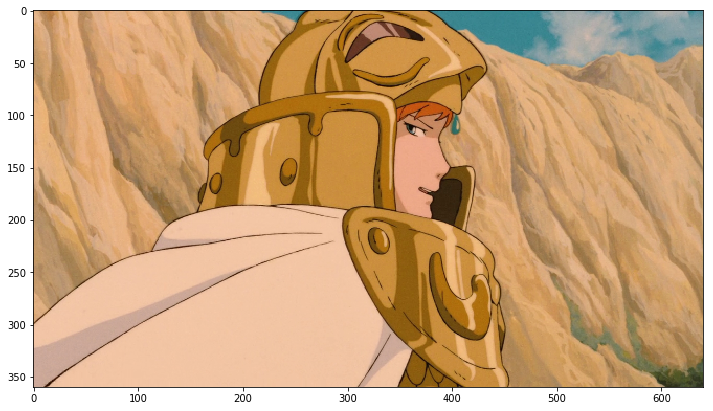

In [16]:
images_list = get_files("..\Data\Images\\*", '*.jpg')
img_hsv = load_image(images_list[random.randint(1,20000)])[...,0:3] / 255 
v = img_hsv[..., 2]
h = img_hsv[..., 0]
s = img_hsv[..., 1]
img_rgb = color.hsv2rgb(np.dstack((h,s,v)))
r = img_rgb[..., 2]
g = img_rgb[..., 1]
b = img_rgb[..., 0]

plt.imshow(np.dstack((r,g,b)))

In [40]:
img_hsv

array([[[ 0.6484375 ,  0.578125  ,  0.234375  ],
        [ 0.6484375 ,  0.59765625,  0.2265625 ],
        [ 0.6484375 ,  0.62109375,  0.21875   ],
        ..., 
        [ 0.609375  ,  0.5625    ,  0.234375  ],
        [ 0.609375  ,  0.5546875 ,  0.23828125],
        [ 0.609375  ,  0.54296875,  0.2421875 ]],

       [[ 0.6484375 ,  0.578125  ,  0.234375  ],
        [ 0.6484375 ,  0.59765625,  0.2265625 ],
        [ 0.6484375 ,  0.62109375,  0.21875   ],
        ..., 
        [ 0.609375  ,  0.5625    ,  0.234375  ],
        [ 0.609375  ,  0.5546875 ,  0.23828125],
        [ 0.609375  ,  0.54296875,  0.2421875 ]],

       [[ 0.6484375 ,  0.578125  ,  0.234375  ],
        [ 0.6484375 ,  0.59765625,  0.2265625 ],
        [ 0.6484375 ,  0.62109375,  0.21875   ],
        ..., 
        [ 0.609375  ,  0.5625    ,  0.234375  ],
        [ 0.609375  ,  0.5546875 ,  0.23828125],
        [ 0.609375  ,  0.54296875,  0.2421875 ]],

       ..., 
       [[ 0.80078125,  0.3515625 ,  0.06640625],
        